#  Supervised Learning Assignment
###  Decision Tree Analysis

####  S. Parker 2016

This notebook will examine the phishing dataset with decision trees.  It will look at the effectiveness of the decision trees relative to:

*  Levels in the decision tree
*  Number of training samples
*  Bias vs variance calculations
*  Performance metrics (memory used, time to fit, time to predict)

Also explored will be the effect of pre-pruning the data set and how this affects performance.

In [1]:
from sklearn import tree
from sklearn import ensemble
from sklearn import svm
from sklearn import neighbors
from sklearn.externals.six import StringIO  
import pandas as pd
import pydotplus
import numpy as np
import os, sys
import timeit
from IPython.display import display, HTML
from IPython.display import Image 
import matplotlib.pyplot as plt
%matplotlib inline
import arff

from supervised_learning import *

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

####  Control variables for simulation

In [2]:
training_test_split = .65

####  Helper function to allow us to get the size of the learning model

In [3]:
import sys
from numbers import Number
from collections import Set, Mapping, deque

try: # Python 2
    zero_depth_bases = (basestring, Number, xrange, bytearray)
    iteritems = 'iteritems'
except NameError: # Python 3
    zero_depth_bases = (str, bytes, Number, range, bytearray)
    iteritems = 'items'

def getsize(obj_0):
    """Recursively iterate to sum size of object & members."""
    def inner(obj, _seen_ids = set()):
        obj_id = id(obj)
        if obj_id in _seen_ids:
            return 0
        _seen_ids.add(obj_id)
        size = sys.getsizeof(obj)
        if isinstance(obj, zero_depth_bases):
            pass # bypass remaining control flow and return
        elif isinstance(obj, (tuple, list, Set, deque)):
            size += sum(inner(i) for i in obj)
        elif isinstance(obj, Mapping) or hasattr(obj, iteritems):
            size += sum(inner(k) + inner(v) for k, v in getattr(obj, iteritems)())
        # Check for custom object instances - may subclass above too
        if hasattr(obj, '__dict__'):
            size += inner(vars(obj))
        if hasattr(obj, '__slots__'): # can have __slots__ with __dict__
            size += sum(inner(getattr(obj, s)) for s in obj.__slots__ if hasattr(obj, s))
        return size
    return inner(obj_0)

##  Load and prepare training set #1

For this assignment I choose the following two data sets:
    
*  Phishing data set - looks at various attributes of a website address and compute whether the site if a phishing site or not

In [4]:
#df_training, df_testing = loadSpamDataSet()
df_training, df_testing = loadPhishingDataSet()


In [5]:
df_training.head()

0  having_IP_Address  URL_Length  Shortining_Service  having_At_Symbol  \
0                  0           0                   0                 0   
1                  1           0                   0                 0   
2                  1           1                   0                 0   
3                  1           1                   0                 0   
4                  1           1                   1                 0   

0  double_slash_redirecting  Prefix_Suffix  having_Sub_Domain  SSLfinal_State  \
0                         0              0                  0               0   
1                         1              0                  1               1   
2                         1              0                  0               0   
3                         1              0                  0               0   
4                         1              0                  2               1   

0  Domain_registeration_length  Favicon   ...    popUpWidnow  Iframe  \
0                            0        0   ...              0       0   
1                            0        0   ...              0       0   
2                            0        0   ...              0       0   
3                            1        0   ...              0       0   
4                            0        0   ...              1       0   

0  age_of_domain  DNSRecord  web_traffic  Page_Rank  Google_Index  \
0              0          0            0          0             0   
1              0          0            1          0             0   
2              1          0            2          0             0   
3              0          0            2          0             0   
4              0          0            1          0             0   

0  Links_pointing_to_page  Statistical_report  Result  
0                       0                   0       0  
1                       0                   1       0  
2                       1                   0       0  
3                       2                   1       0  
4                       0                   1       1  

[5 rows x 31 columns]

##  Vary Decision Tree Depth to see effect on training and testing sets

In [6]:
clf = tree.DecisionTreeClassifier()

In [7]:
df_training.columns.values

array(['having_IP_Address', 'URL_Length', 'Shortining_Service',
       'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix',
       'having_Sub_Domain', 'SSLfinal_State',
       'Domain_registeration_length', 'Favicon', 'port', 'HTTPS_token',
       'Request_URL', 'URL_of_Anchor', 'Links_in_tags', 'SFH',
       'Submitting_to_email', 'Abnormal_URL', 'Redirect', 'on_mouseover',
       'RightClick', 'popUpWidnow', 'Iframe', 'age_of_domain', 'DNSRecord',
       'web_traffic', 'Page_Rank', 'Google_Index',
       'Links_pointing_to_page', 'Statistical_report', 'Result'], dtype=object)

In [8]:
clf.fit(df_training.values[:,0:-1], df_training.values[:,-1])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

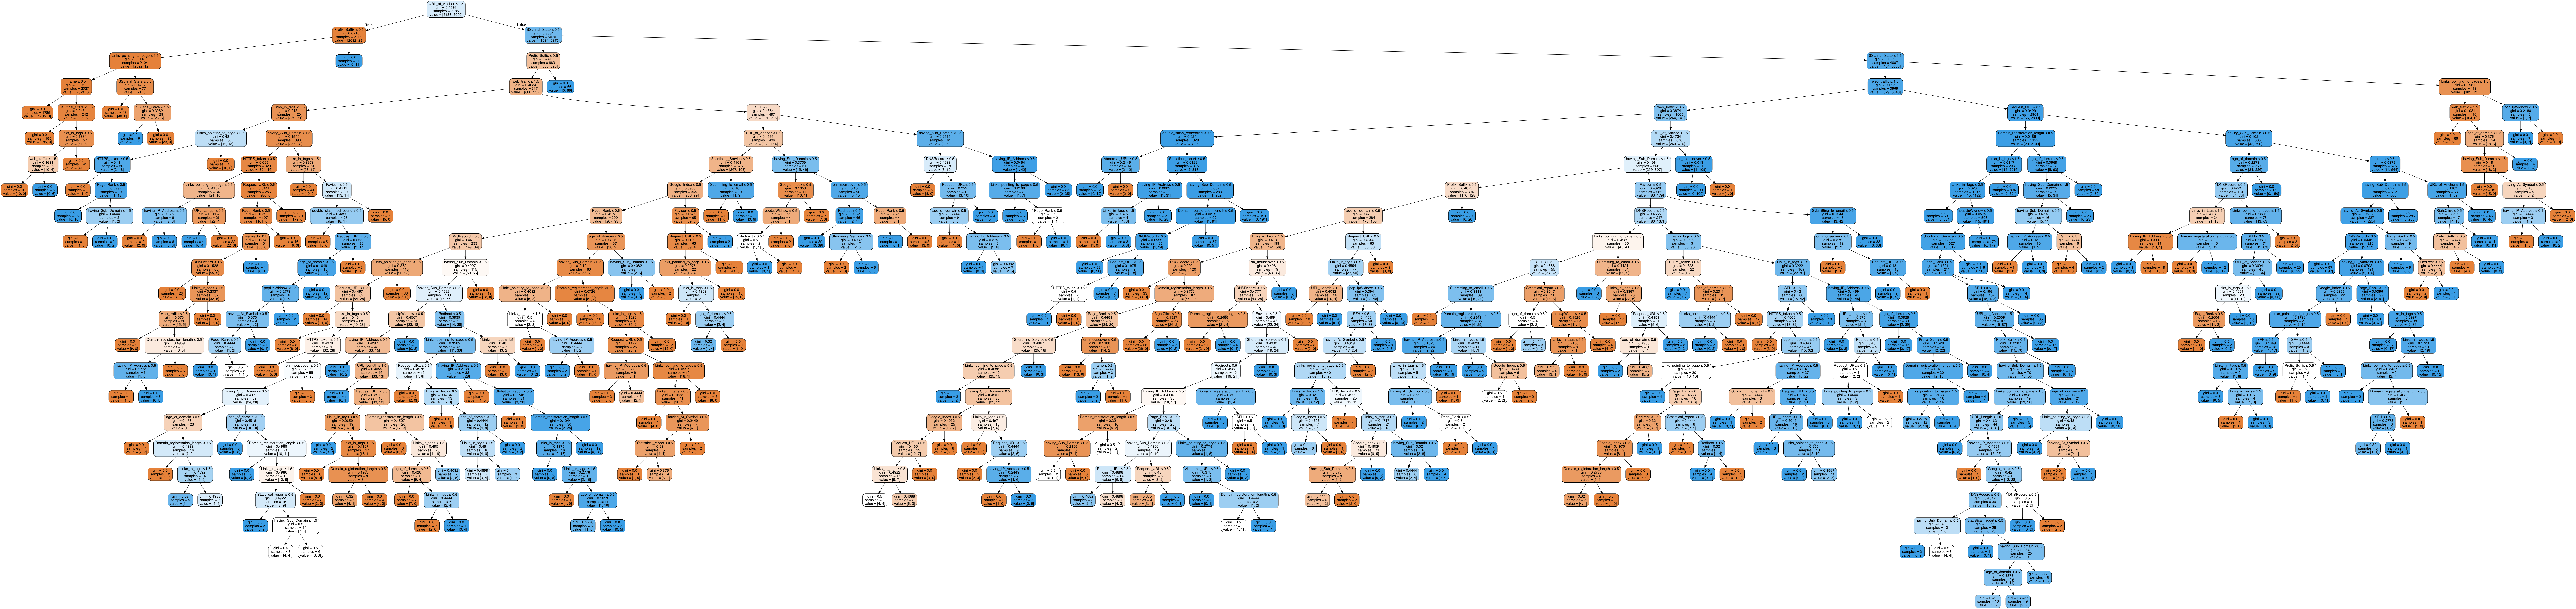

In [9]:
dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                     feature_names=df_training.columns.values[0:-1],  
                     #class_names=["False", "True"],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 

####  Feature Importance.  For this part of the study, we will look at different features at look at their importance relative to the overall decision tree.

In [10]:
len(clf.feature_importances_)

30

In [11]:
df_importance = pd.DataFrame()
df_importance["attribute"] = list(df_training.columns.values)[0:-1]
df_importance["importance"] = clf.feature_importances_
display(df_importance.sort_values(by="importance", ascending=0))

attribute  importance
13                URL_of_Anchor    0.536116
7                SSLfinal_State    0.193211
25                  web_traffic    0.057709
5                 Prefix_Suffix    0.030286
14                Links_in_tags    0.030064
6             having_Sub_Domain    0.021610
28       Links_pointing_to_page    0.016092
23                age_of_domain    0.015536
15                          SFH    0.013159
24                    DNSRecord    0.011828
12                  Request_URL    0.008446
8   Domain_registeration_length    0.007838
0             having_IP_Address    0.007095
26                    Page_Rank    0.006128
11                  HTTPS_token    0.005615
19                 on_mouseover    0.005048
9                       Favicon    0.004573
1                    URL_Length    0.004329
2            Shortining_Service    0.004269
27                 Google_Index    0.003627
16          Submitting_to_email    0.003620
18                     Redirect    0.003025
21                  popUpWidnow    0.002327
20                   RightClick    0.002074
4      double_slash_redirecting    0.001817
3              having_At_Symbol    0.001550
29           Statistical_report    0.001425
17                 Abnormal_URL    0.001041
22                       Iframe    0.000542
10                         port    0.000000

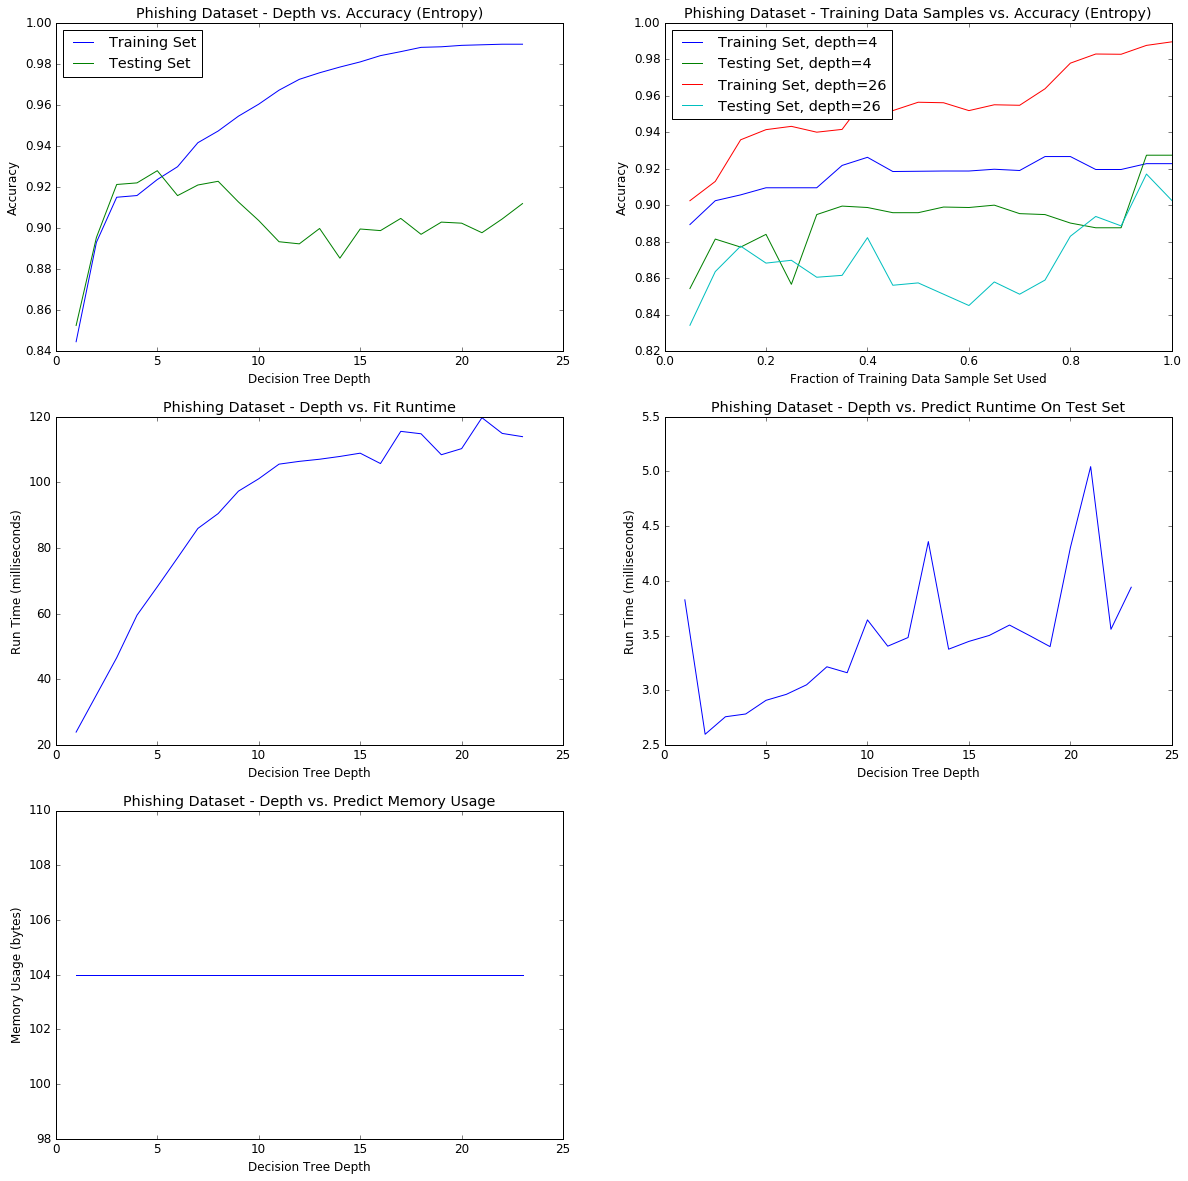

In [17]:
training_accuracy = []
testing_accuracy = []
fit_run_time = []
predict_run_time= []
memory_usage = []

depth_range = range(1,24)

for depth in depth_range:
    clf = tree.DecisionTreeClassifier(criterion="gini", max_depth=depth)
    fit_run_time.append(timeit.timeit("clf.fit(df_training.values[:,0:-2], df_training.values[:,-1])", 
                    "from __main__ import clf, df_training",
                     number = 10))
    
    clf = tree.DecisionTreeClassifier(criterion="gini", max_depth=depth)
    clf.fit(df_training.values[:,0:-2], df_training.values[:,-1])
    memory_usage.append(getsize(clf.tree_))
    
    training_accuracy.append(clf.score(df_training.values[:,0:-2], df_training.values[:,-1]))
    testing_accuracy.append(clf.score(df_testing.values[:,0:-2], df_testing.values[:,-1]))
    
    predict_run_time.append(timeit.timeit("clf.score(df_testing.values[:,0:-2], df_testing.values[:,-1])",
                                          "from __main__ import clf, df_testing",
                                          number=5))
plt.rcParams.update({'font.size': 12})    
fig = plt.figure(figsize=(20,20))    
    
plt.subplot(321)
plt.plot(depth_range, training_accuracy)
plt.plot(depth_range, testing_accuracy)
plt.title("Phishing Dataset - Depth vs. Accuracy (Entropy)")
plt.xlabel("Decision Tree Depth")
plt.ylabel("Accuracy")
plt.legend(["Training Set", "Testing Set"], loc=2)

plt.subplot(323)
plt.title("Phishing Dataset - Depth vs. Fit Runtime")
plt.plot(depth_range, np.array(fit_run_time) * 1000)
plt.ylabel("Run Time (milliseconds)")
plt.xlabel("Decision Tree Depth")

plt.subplot(324)
plt.title("Phishing Dataset - Depth vs. Predict Runtime On Test Set")
plt.plot(depth_range, np.array(predict_run_time) * 1000)
plt.ylabel("Run Time (milliseconds)")
plt.xlabel("Decision Tree Depth")

plt.subplot(325)
plt.title("Phishing Dataset - Depth vs. Predict Memory Usage")
plt.plot(depth_range, memory_usage)
plt.ylabel("Memory Usage (bytes)")
plt.xlabel("Decision Tree Depth")

training_accuracy = []
testing_accuracy = []

percent_of_training_data = np.arange(.05,1.05,.05)
for depth in [5, 24]:
    new_training_accuracy = []
    new_testing_accuracy = []
    for percent in percent_of_training_data:
        clf = tree.DecisionTreeClassifier(criterion="gini", max_depth=depth)
        clf.fit(df_training.values[0:int(percent * len(df_training)),0:-2], \
                df_training.values[0:int(percent * len(df_training)),-1])
    
        new_training_accuracy.append(clf.score(df_training.values[:,0:-2], df_training.values[:,-1]))
        new_testing_accuracy.append(clf.score(df_testing.values[:,0:-2], df_testing.values[:,-1]))
    
    predict_run_time.append(timeit.timeit("clf.score(df_testing.values[:,0:-2], df_testing.values[:,-1])",
                                          "from __main__ import clf, df_testing",
                                          number=5))
    
    training_accuracy.append(new_training_accuracy)
    testing_accuracy.append(new_testing_accuracy)

plt.subplot(322)
#plt.figure()
plt.plot(percent_of_training_data, training_accuracy[0])
plt.plot(percent_of_training_data, testing_accuracy[0])
plt.plot(percent_of_training_data, training_accuracy[1])
plt.plot(percent_of_training_data, testing_accuracy[1])
plt.title("Phishing Dataset - Training Data Samples vs. Accuracy (Entropy)")
plt.xlabel("Fraction of Training Data Sample Set Used")
plt.ylabel("Accuracy")
plt.legend(["Training Set, depth=4", "Testing Set, depth=4",
           "Training Set, depth=26", "Testing Set, depth=26"], loc=2)



Now let's look at an example with some pruning.

In [13]:
class EvaluateDecisionTree:
    
    def __init__(self, df_training, df_testing, criterion):
        self.training_accuracy = []
        self.testing_accuracy = []
        self.fit_run_time = []
        self.predict_run_time= []
        self.memory_usage = []
        
        self.percentage_range = np.arange(0.05, 1.05, .05)
        
        for percent in self.percentage_range:
            clf = tree.DecisionTreeClassifier(criterion="gini", max_depth=depth)
            clf.fit(df_training.values[0:int(percent * len(df_training)),0:-2], \
                df_training.values[0:int(percent * len(df_training)),-1])
    
            self.training_accuracy.append(clf.score(df_training.values[:,0:-2], df_training.values[:,-1]))
            self.testing_accuracy.append(clf.score(df_testing.values[:,0:-2], df_testing.values[:,-1]))
    
            self.predict_run_time.append(timeit.timeit("clf.score(df_testing.values[:,0:-2], df_testing.values[:,-1])",
                                          "from __main__ import clf, df_testing",
                                          number=5))
            
    def plot_training_accuracy(self):
        plt.plot(self.percentage_range, self.training_accuracy)

    def plot_testing_accuracy(self):
        plt.plot(self.percentage_range, self.testing_accuracy)

    def plot_fit_run_time(self):
        plt.plot(self.percentage_range, self.fit_run_time)

    def plot_predict_run_time(self):
        plt.plot(self.percentage_range, self.predict_run_time)

    def plot_memory_usage(self):
        plt.plot(self.percentage_range, self.memory_usage)


In [14]:
no_pruning_entropy = EvaluateDecisionTree(df_training, df_testing, "entropy")
no_pruning_gini    = EvaluateDecisionTree(df_training, df_testing, "gini")

df_training_pruned = df_training.drop(df_importance[df_importance["importance"] < .02]["attribute"].values, 1)
df_testing_pruned  = df_testing.drop(df_importance[df_importance["importance"] < .02]["attribute"].values, 1)

pruned_entropy = EvaluateDecisionTree(df_training_pruned, df_testing_pruned, "entropy")
pruned_gini    = EvaluateDecisionTree(df_training_pruned, df_testing_pruned, "gini")

fig = plt.figure(figsize=(20,20))  



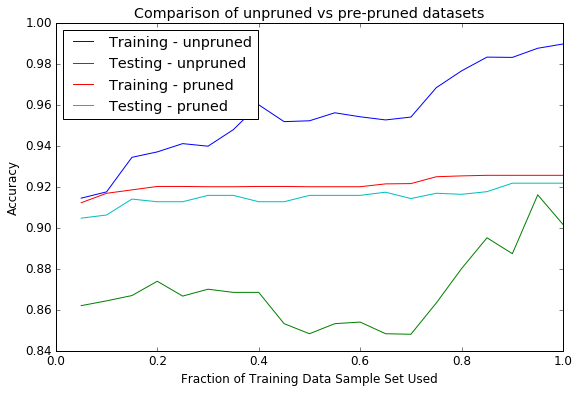

In [16]:
fig = plt.figure(figsize=(20,20))    
plt.subplot(321)

no_pruning_entropy.plot_training_accuracy()
no_pruning_entropy.plot_testing_accuracy()
pruned_entropy.plot_training_accuracy()
pruned_entropy.plot_testing_accuracy()

plt.title("Comparison of unpruned vs pre-pruned datasets")
plt.ylabel("Accuracy")
plt.xlabel("Fraction of Training Data Sample Set Used")
plt.legend(["Training - unpruned", "Testing - unpruned", "Training - pruned", "Testing - pruned"], loc=2)